In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
f = open('kddcup.names')
columns = f.readlines()
columns = [i.split(':')[0] for i in columns]
columns = columns[1:] + ['outcome']
f.close()

df = pd.read_csv('kddcup.data.corrected',header=None,names=columns)
df.reset_index(drop=True,inplace=True)
print df.shape
display(df.head())

(4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
df['outcome'] = df['outcome'].apply(lambda x: x.replace('.',''))
df['binary_outcome'] = df['outcome'].apply(lambda x: 1 if x!= 'normal' else 0)

In [40]:
display(df[['binary_outcome']].value_counts())
display(df[['outcome']].value_counts())

,binary_outcome
1,3925650
0,972781


,outcome
smurf,2807886
neptune,1072017
normal,972781
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979


,num_access_files
count,4.898431e+06
mean,1.021143e-03
std,3.551048e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,9.000000e+00


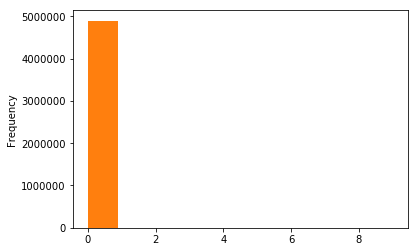

,src_bytes
count,4.898431e+06
mean,1.834621e+03
std,9.414311e+05
min,0.000000e+00
25%,4.500000e+01
50%,5.200000e+02
75%,1.032000e+03
max,1.379964e+09


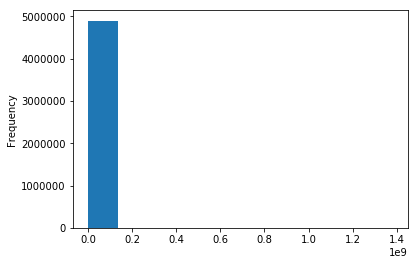

,srv_count
count,4.898431e+06
mean,2.952671e+02
std,2.459927e+02
min,0.000000e+00
25%,1.000000e+01
50%,5.100000e+02
75%,5.110000e+02
max,5.110000e+02


KeyboardInterrupt: 

In [57]:
pd.options.display.max_columns=50
for c in set(df.columns)-set(['outcome','binary_outcome']):
    if(str(df.dtypes[c]) != 'object'):
        display(df[[c]].describe())
        df[c].plot.hist()
        plt.show()
        plt.close()
    else:
        display(df[[c]].value_counts().to_frame())

In [4]:
# drop these low information variables
df.drop(['is_host_login','num_outbound_cmds','land'],axis=1,inplace=True)

In [7]:
exclude = ['outcome','binary_outcome']
model_vars = list(set(df.columns) - set(exclude))
loo_vars = ['service','flag']

In [6]:
from loo import loo
kf = KFold(n_splits=10,random_state=10)

In [11]:
# cv with gradient boost
for train,test in kf.split(df):
    print 'make LOO'
    %time ltab = loo(df=df.loc[train,['binary_outcome'] + loo_vars],vars=loo_vars,yvar='binary_outcome')
    print '\n'
    
    print 'get LOO columns'
    %time loo_train = ltab.applyLookup(df=df.loc[train,['binary_outcome'] + loo_vars],trainVar='binary_outcome',trainValue=[1,0])
    %time loo_test = ltab.applyLookup(df=df.loc[test,['binary_outcome'] + loo_vars],trainVar='binary_outcome',trainValue=[2])
    print '\n'
    
    for i in ['loo_' + i for i in loo_vars]:
        df[i] = np.float64()
        df,loc[train,i] = loo_train[i]
        df,loc[test,i] = loo_test[i]
        
    del loo_train,loo_test,ltab

    display(df.head(20))
    
for i in df.columns:
    if i[:4] == 'loo_':
        del df[i]

make LOO
CPU times: user 1.05 s, sys: 112 ms, total: 1.16 s
Wall time: 1.17 s


get LOO columns


MemoryError: 